# Part A: Run Following Section for Needed Functions

In [1]:
!pip install --upgrade --no-cache-dir gdown
!pip install pytorch_lightning &> /dev/null
!gdown 1YuFkOkeZ_3iaf71W1QfaZqqO9nZq_QUy
!gdown 1PDctbNuLSpxVU6MA-Qy6Unf_Q-bQf0jd
!gdown 1_fR9WLy10WRzlZQBaMv8BFkT4f_4xr99
!gdown 1oSiBPjyxMOaC496rLVQA-xG-fgK1ulcA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=1YuFkOkeZ_3iaf71W1QfaZqqO9nZq_QUy
To: /content/hw3_mycocodata_mask_comp_zlib.h5
100% 4.30M/4.30M [00:00<00:00, 17.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PDctbNuLSpxVU6MA-Qy6Unf_Q-bQf0jd
To: /content/hw3_mycocodata_labels_comp_zlib.npy
100% 269k/269k [00:00<00:00, 127MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_fR9WLy10WRzlZQBaMv8BFkT4f_4xr99
To: /content/hw3_mycocodata_img_comp_zlib.h5
100% 801M/801M [00:39<00:00, 20.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oSiBPjyxMOaC496rLVQA-xG-fgK1ulcA
To: /content/hw3_mycocodata_bboxes_comp_zlib.npy
100% 327k/327k [00:00<00:00, 133MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from sklearn import metrics
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
from inspect import modulesbyfile
from tqdm import tqdm
import h5py
import albumentations as A
from PIL import Image
from skimage.transform import resize
import warnings
from RPNHead import *
from utils import *

warnings.filterwarnings('ignore')
torch.set_printoptions(linewidth=100)
np.set_printoptions(linewidth=100)
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed);

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50_fpn = Resnet50Backbone()
# backbone = Resnet50Backbone('checkpoint680.pth')
E = torch.ones([2,3,800,1088], device=device)
backout = resnet50_fpn(E)
print(backout.keys())
print(backout["0"].shape)
print(backout["1"].shape)
print(backout["2"].shape)
print(backout["3"].shape)
print(backout["pool"].shape)

odict_keys(['0', '1', '2', '3', 'pool'])
torch.Size([2, 256, 200, 272])
torch.Size([2, 256, 100, 136])
torch.Size([2, 256, 50, 68])
torch.Size([2, 256, 25, 34])
torch.Size([2, 256, 13, 17])


# Part A: Run Following Section To Train Model

In [3]:
# load the data into data.Dataset
device = 'cuda'

labels_og, bbox_og, imgs, masks_og= load_datset(viz=False)
dataset = BuildDataset(imgs, labels_og, bbox_og, masks_og)

# build the dataloader
# set 20% of the dataset as the training data
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size

# random split the dataset into training and testset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# push the randomized training data into the dataloader
batch_size = 2
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=dataset.collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=dataset.collate_fn)
batch_tr = len(train_loader)
batch_val = len(test_loader)

In [4]:
device = torch.device("cuda:0" if use_cuda else "cpu")

model = RPNHead(batch_tr,batch_val).to(device)
# ground_dict = torch.load("/content/drive/My Drive/680/Final project/Mission_Dict/ground_dict_2000.pth")
# model.ground_dict = ground_dict

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath='/content/drive/My Drive/680/Final Project/model_change/', every_n_epochs=1, filename='{epoch}_Model')
tb_logger = pl_loggers.TensorBoardLogger('')

# Train
trainer = pl.Trainer(logger=tb_logger, max_epochs=36, callbacks=[checkpoint_callback], accelerator='cuda')
# trainer = pl.Trainer(logger=tb_logger, max_epochs=36, callbacks=[checkpoint_callback], accelerator='cuda', resume_from_checkpoint='/content/drive/My Drive/680/Final Project/model_change/epoch=10_Model.ckpt')

trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | bceloss            | BCELoss         | 0     
1 | smoothl1           | SmoothL1Loss    | 0     
2 | intermediate_layer | Sequential      | 590 K 
3 | classhead          | Sequential      | 771   
4 | reghead            | Sequential      | 3.1 K 
5 | backbone           | BackboneWithFPN | 26.8 M
-------------------------------------------------------
27.2 M    Trainable params
222 K     Non-trainable params
27.4 M    Total params
10

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# Part C: Run Following Section for Results

In [4]:
model = RPNHead(batch_tr,batch_val).to(device)
for i,batch in enumerate(train_loader,):
    images_, labels_, boxes_, masks, indexes_ = batch
    gt_,ground_coord_=model.create_batch_truth(boxes_,indexes_,images_.shape[-2:])
    break

### Vizualize Ground Truth at across FPN Levels

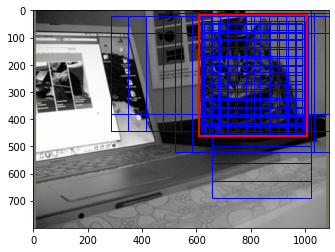

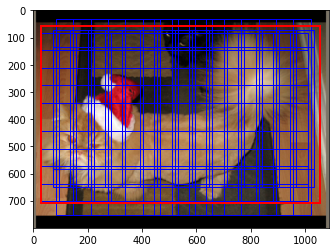

In [5]:
viz_all_pos(gt_, ground_coord_, images_, model)

### Vizualize Ground Truth at each FPN Level

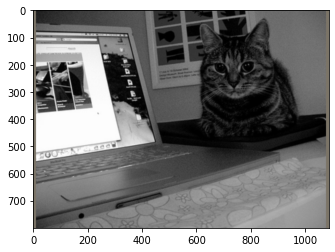

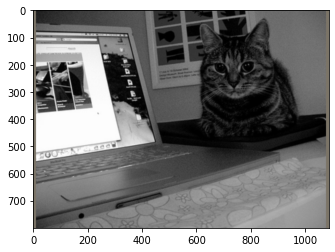

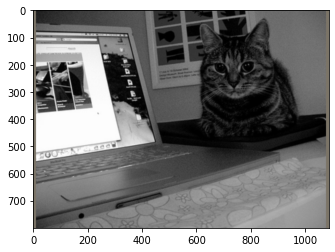

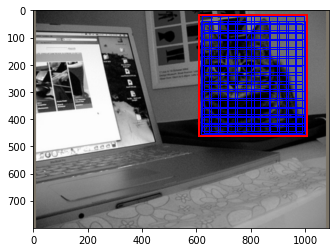

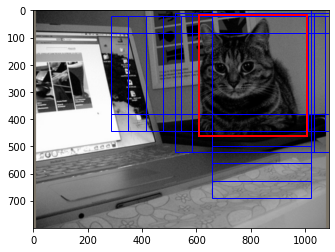

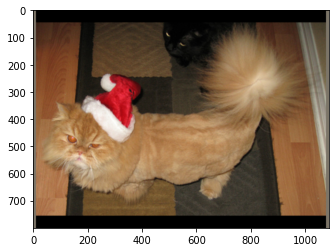

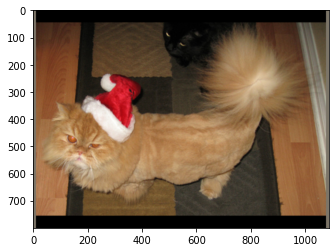

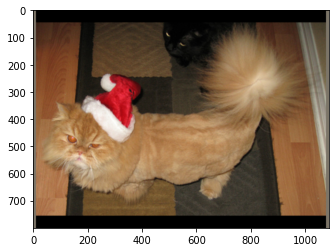

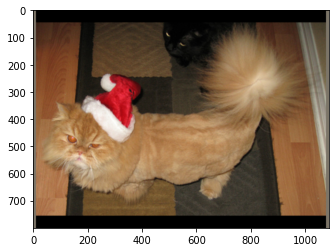

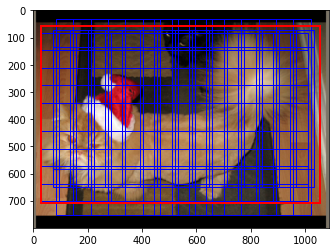

In [6]:
viz_all_levels(gt_, ground_coord_, images_, model)

### Vizualize Ground Truth at across FPN Levels and Each Aspect ratio

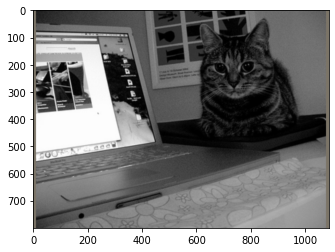

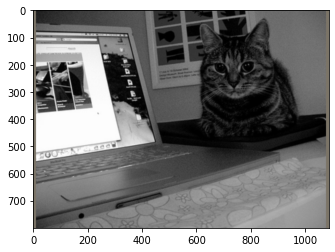

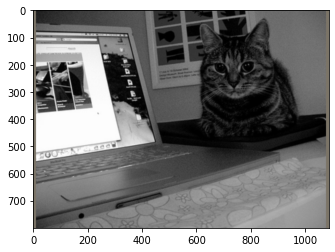

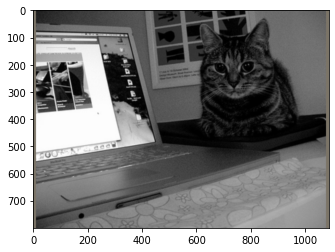

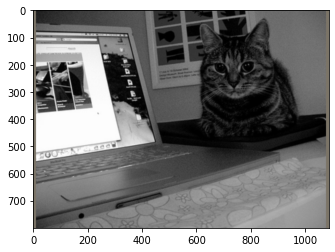

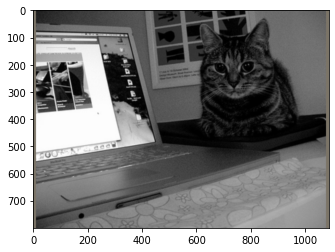

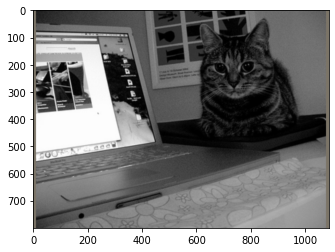

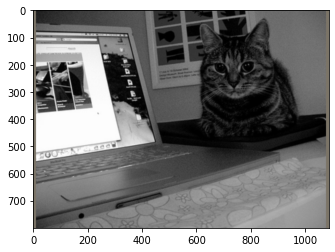

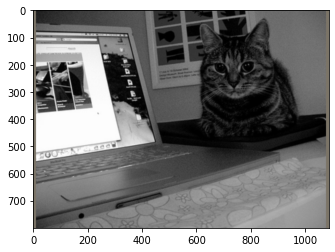

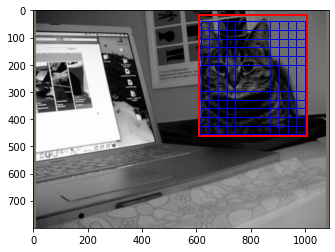

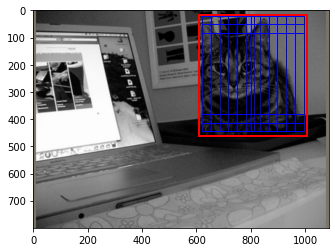

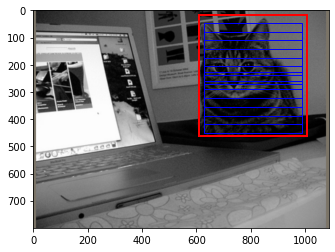

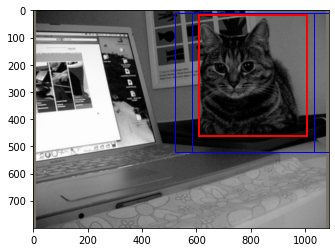

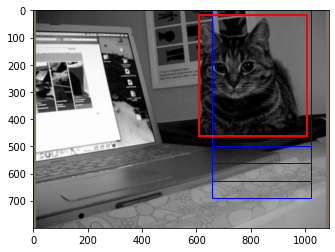

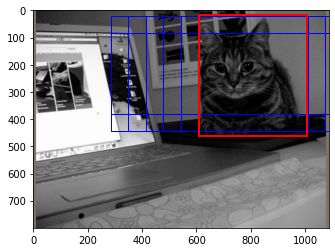

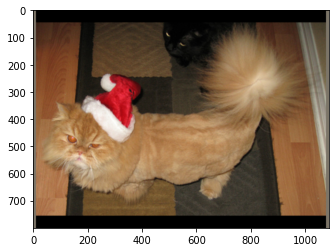

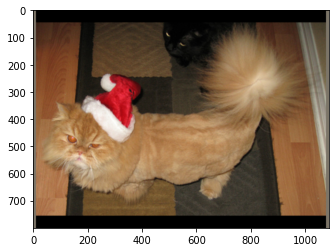

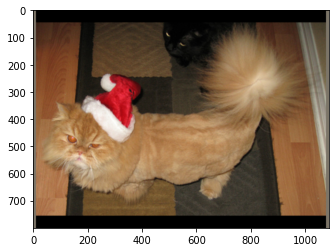

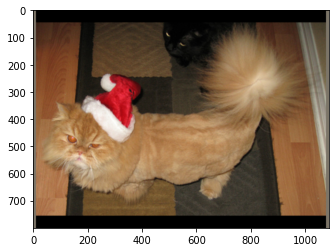

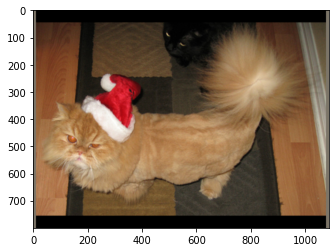

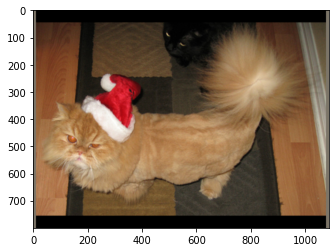

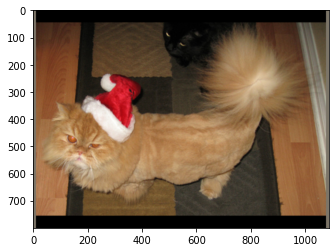

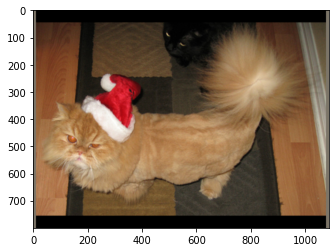

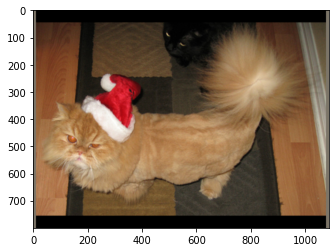

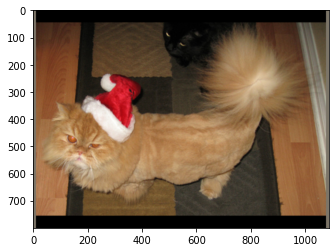

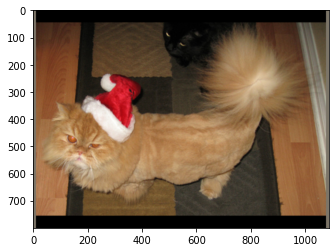

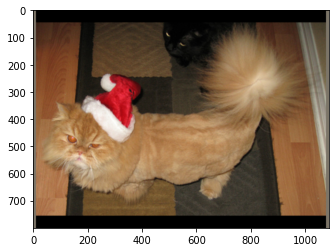

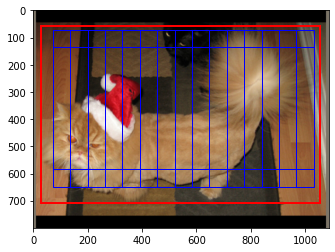

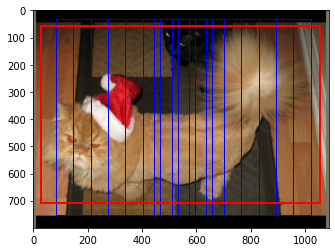

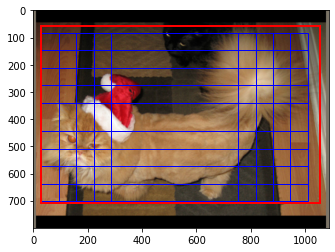

In [7]:
viz_all_levels_all_asp(gt_, ground_coord_, images_, model)

### Top K results

In [ ]:
# After Training 
device='cuda'
model = RPNHead.load_from_checkpoint(checkpoint_path='/content/drive/My Drive/680/Final Project/model_change/epoch=21_Model.ckpt')
model =  model.to(device)

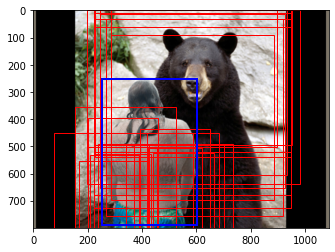

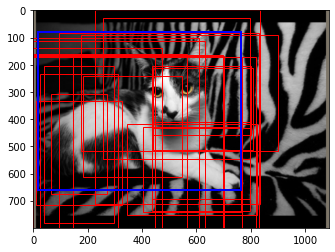

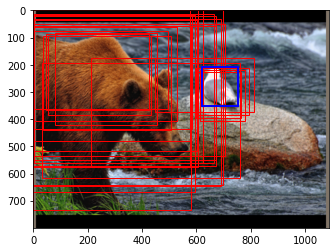

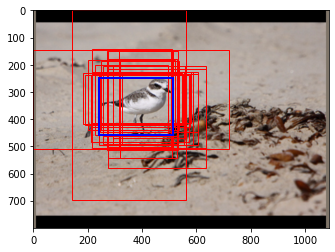

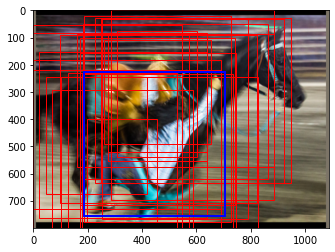

In [ ]:
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=dataset.collate_fn)

for i in range(5):
  images, labels, bbox, masks, index = next(iter(test_loader))
  images=images.to(device)
  model.topK_plotter(images, bbox[0], 25)

### After NMS

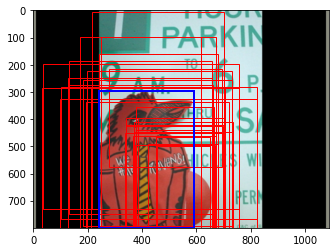

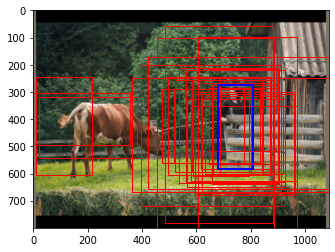

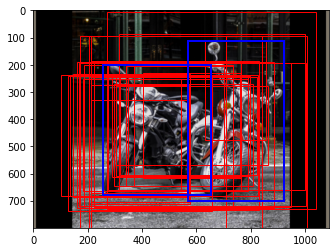

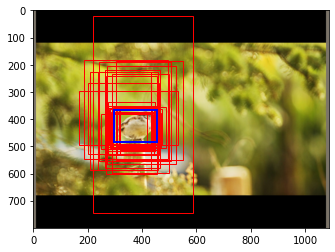

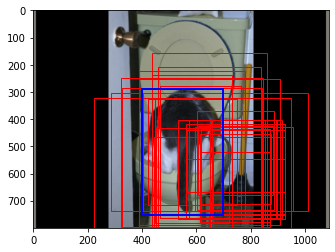

In [ ]:
for i in range(5):
  images, labels, bbox, masks, index = next(iter(test_loader))
  images=images.to(device)
  model.nms_plotter(images, bbox[0], 100,30)
  print("================================================================")

### Results: Plots

In [ ]:
def plot_graphs():
  # Results from Best Model
  total_loss= [14.30114282610588, 4.71285716388346, 3.968766215612476, 3.746914552601702, 3.4814077061223037, 3.4435925504241203, 3.3180751378831967, 2.2620296880580018, 1.9528310962968363, 1.8210746894660441, 1.7128357175754734, 1.6275236329568656, 1.4575140494254246, 1.435490384104606, 1.4107155204389763, 1.406066450645511, 1.389990477886901, 1.3847154471538334, 1.3697939743423353, 1.348091342079968, 1.3450658471989596, 1.3423586530899017, 1.3427293128569313, 1.3463478181254445, 1.3380302673185767, 1.3390194133585847, 1.336270723896954, 1.341576088465191, 1.3376934311565176, 1.3423412973218087]
  closs=  [0.6942663382493519, 0.396420102124352, 0.3288178213773606, 0.31304351400703784, 0.30138582936495223, 0.3030896992672229, 0.30397709361655467, 0.25812869170569397, 0.23541891943252607, 0.22144016356151808, 0.21213223254037122, 0.20406574084442022, 0.19218595876432612, 0.1948831975231857, 0.1917480586048866, 0.19261352824629105, 0.1904090998457548, 0.18951380963239015, 0.18872479836144135, 0.1900254604028706, 0.1851813735213604, 0.18555267415455845, 0.18523054315878298, 0.18664442837112805, 0.18754877402713868, 0.18753894140864016, 0.18401325614281444, 0.1882066338196123, 0.18879882282374932, 0.188079550609158] 
  rloss= [13.606876569356524, 4.3164370661490175, 3.639948396551299, 3.4338710361929072, 3.180021879318845, 3.140502849590906, 3.0140980409078906, 2.003900997055435, 1.71741217755888, 1.5996345257069944, 1.500703484550187, 1.4234578915020226, 1.265328090655037, 1.2406071859767025, 1.2189674607006002, 1.2134529234553368, 1.1995813768431203, 1.1952016379849653, 1.181069177425656, 1.1580658804562518, 1.159884474829273, 1.156805976803142, 1.1574987696788943, 1.1597033910578827, 1.1504814925547946, 1.151480471444349, 1.1522574657617082, 1.1533694554342793, 1.1488946095839212, 1.1542617441547227]

  total_val_loss=  [5.64405353280747, 5.047386975827932, 4.11677313707655, 4.2729177176040976, 4.162775260228265, 4.057533516067248, 4.483632861109684, 3.4077165414798514, 3.3575821588163346, 3.3184669504471875, 3.319872597306511, 3.3420072976237774, 3.2685540066946537, 3.294315442944156, 3.2910050647703515, 3.301504138048271, 3.3039113701483527, 3.3124244313356708, 3.3012714737781326, 3.2937108648297255, 3.2982722329437184, 3.3277423839321196, 3.301789968385609, 3.287739611000096, 3.3041396224899757, 3.291066804427984, 3.3137795544181032, 3.3028190469523087, 3.3213551737117477, 3.3016370545833484]
  closs_val= [0.46964129185822395, 0.3536829811489546, 0.35144216398671496, 0.3289766578111991, 0.34901060351948127, 0.3362891542118624, 0.3393306220662339, 0.2960021406104532, 0.29369915608567293, 0.27489121782305775, 0.2710294714567767, 0.2866237901453077, 0.2756208463369752, 0.27252743034039706, 0.27855522843470815, 0.28591986970879163, 0.27564154613894104, 0.2816979632305625, 0.2799035741090319, 0.2734213279195654, 0.2878668375102524, 0.26955410243732575, 0.2763650513023411, 0.27404236504722623, 0.27153967731897166, 0.28212531299019855, 0.27628285570542926, 0.2757375344252413, 0.27909456766481067, 0.2801778975999501]
  rloss_val=  [5.174412251247908, 4.693704015253516, 3.7653309744796988, 3.943941065659946, 3.8137646532569094, 3.721244371630001, 4.144302216873985, 3.111714399735862, 3.0638830012866847, 3.0435757345380403, 3.048843128418704, 3.05538351400912, 2.992933152283368, 3.021788014002167, 3.012449841615986, 3.015584266878414, 3.0282698243583015, 3.030726469073456, 3.0213678950381206, 3.0202895354604866, 3.0104053933686075, 3.0581882834799066, 3.025424925650296, 3.013697238052292, 3.0325999493263547, 3.0089414912626284, 3.0374966961892738, 3.0270815129856086, 3.04226061154943, 3.021459156037835]

  # Training Loss vs Epochs
  plt.plot(range(len(total_loss)), total_loss, label="Train Loss")
  plt.plot(range(len(total_val_loss)), total_val_loss, label="Validation Loss")
  plt.title("Epoch Vs Total Loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  plt.plot(range(len(closs)), closs, label="Train Category Loss")
  plt.plot(range(len(closs_val)), closs_val, label="Validation Category Loss")
  plt.title("Epoch Vs Category Loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  plt.plot(range(len(rloss)), rloss, label="Train Regressor Loss")
  plt.plot(range(len(rloss_val)), rloss_val, label="Validation Regressor Loss")
  plt.title("Epoch Vs Regressor Loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

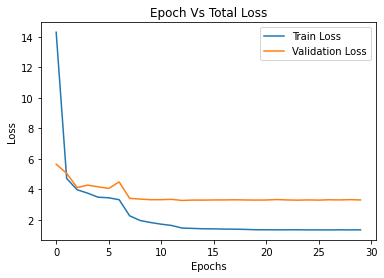

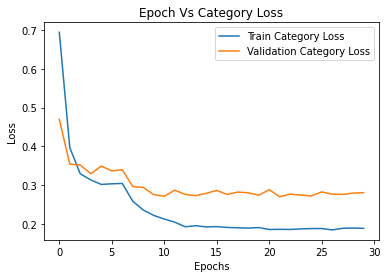

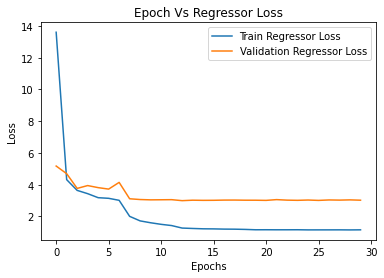

In [ ]:
plot_graphs()